ARIS R&D   Development
-------
here we are experimenting different models like MTCNN , YOLO , DLIB and mobile net v2 to compare which model do we have to work on.



In [15]:
import sys
import torch
import matplotlib.pyplot as plt
import cv2
import time
import tensorflow as tf
import numpy as np
import math
import dlib

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from mtcnn.mtcnn import MTCNN
detector = MTCNN()

# create an object to read 
# camera

sample = 'F:\CollegeStuff\Dataset for Experiment for face detection\dataset experiment.mp4'


In [16]:
# Initializing Dliub


def process_dlib_boxes(box):
    xmin = box.rect.left()
    ymin = box.rect.top()
    xmax = box.rect.right()
    ymax = box.rect.bottom()
    return [int(xmin), int(ymin), int(xmax), int(ymax)]

    

In [17]:
!pip install mtcnn


In [18]:
from mtcnn import MTCNN
mtcnn = MTCNN()



YOLOv3 Initalzation

In [19]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
def load_mobilenetv2_224_075_detector(path):
    input_tensor = Input(shape=(224, 224, 3))
    output_tensor = MobileNetV2(weights=None, include_top=False, input_tensor=input_tensor, alpha=0.75).output
    output_tensor = ZeroPadding2D()(output_tensor)
    output_tensor = Conv2D(kernel_size=(3, 3), filters=5)(output_tensor)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.load_weights(path)
    return model



In [20]:
mobilenetv2 = load_mobilenetv2_224_075_detector(r"C:\Users\91708\Downloads\archive (3)\facedetection-mobilenetv2-size224-alpha0.75.h5")

In [21]:
def transpose_shots(shots):
    return [(shot[1], shot[0], shot[3], shot[2], shot[4]) for shot in shots]


SHOTS = {
    # fast less accurate
    '2-16/9' : {
        'aspect_ratio' : 16/9,
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1)
        ]
    },
    # slower more accurate
    '10-16/9' : {
        'aspect_ratio' : 16/9,
        'shots' : [
             (0, 0, 9/16, 1, 1),
             (7/16, 0, 9/16, 1, 1),
             (0, 0, 5/16, 5/9, 0.5),
             (0, 4/9, 5/16, 5/9, 0.5),
             (11/48, 0, 5/16, 5/9, 0.5),
             (11/48, 4/9, 5/16, 5/9, 0.5),
             (22/48, 0, 5/16, 5/9, 0.5),
             (22/48, 4/9, 5/16, 5/9, 0.5),
             (11/16, 0, 5/16, 5/9, 0.5),
             (11/16, 4/9, 5/16, 5/9, 0.5),
        ]
    }
}

SHOTS_T = {
    '2-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['2-16/9']['shots'])
    },
    '10-9/16' : {
        'aspect_ratio' : 9/16,
        'shots' : transpose_shots(SHOTS['10-16/9']['shots'])
    }
}

def r(x):
    return int(round(x))

def sigmoid(x):
    return 1 / (np.exp(-x) + 1)

def non_max_suppression(boxes, p, iou_threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort(p)
    true_boxes_indexes = []

    while len(indexes) > 0:
        true_boxes_indexes.append(indexes[-1])

        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        iou = intersection / ((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]) + (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]) - intersection)

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, np.where(iou >= iou_threshold)[0])

    return boxes[true_boxes_indexes]

def union_suppression(boxes, threshold):
    if len(boxes) == 0:
        return np.array([])

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    indexes = np.argsort((x2 - x1) * (y2 - y1))
    result_boxes = []

    while len(indexes) > 0:
        intersection = np.maximum(np.minimum(x2[indexes[:-1]], x2[indexes[-1]]) - np.maximum(x1[indexes[:-1]], x1[indexes[-1]]), 0) * np.maximum(np.minimum(y2[indexes[:-1]], y2[indexes[-1]]) - np.maximum(y1[indexes[:-1]], y1[indexes[-1]]), 0)
        min_s = np.minimum((x2[indexes[:-1]] - x1[indexes[:-1]]) * (y2[indexes[:-1]] - y1[indexes[:-1]]), (x2[indexes[-1]] - x1[indexes[-1]]) * (y2[indexes[-1]] - y1[indexes[-1]]))
        ioms = intersection / (min_s + 1e-9)
        neighbours = np.where(ioms >= threshold)[0]
        if len(neighbours) > 0:
            result_boxes.append([min(np.min(x1[indexes[neighbours]]), x1[indexes[-1]]), min(np.min(y1[indexes[neighbours]]), y1[indexes[-1]]), max(np.max(x2[indexes[neighbours]]), x2[indexes[-1]]), max(np.max(y2[indexes[neighbours]]), y2[indexes[-1]])])
        else:
            result_boxes.append([x1[indexes[-1]], y1[indexes[-1]], x2[indexes[-1]], y2[indexes[-1]]])

        indexes = np.delete(indexes, -1)
        indexes = np.delete(indexes, neighbours)

    return result_boxes


class FaceDetector():
    """
    That's API you can easily use to detect faces
    
    __init__ parameters:
    -------------------------------
    model - model to infer
    shots - list of aspect ratios that images could be (described earlier)
    image_size - model's input size (hardcoded for mobilenetv2)
    grids - model's output size (hardcoded for mobilenetv2)
    union_threshold - threshold for union of predicted boxes within multiple shots
    iou_threshold - IOU threshold for non maximum suppression used to merge YOLO detected boxes for one shot,
                    you do need to change this because there are one face per image as I can see from the samples
    prob_threshold - probability threshold for YOLO algorithm, you can balance beetween precision and recall using this threshold
    
    detect parameters:
    -------------------------------
    frame - (1920, 1080, 3) or (1080, 1920, 3) RGB Image
    returns: list of 4 element tuples (left corner x, left corner y, right corner x, right corner y) of detected boxes within [0, 1] range (see box draw code below)
    """
    def __init__(self, model=mobilenetv2, shots=[SHOTS['10-16/9'], SHOTS_T['10-9/16']], image_size=224, grids=7, iou_threshold=0.1, union_threshold=0.1):
        self.model = model
        self.shots = shots
        self.image_size = image_size
        self.grids = grids
        self.iou_threshold = iou_threshold
        self.union_threshold = union_threshold
        self.prob_threshold = 0.7
        
    
    def detect(self, frame, threshold = 0.7):
        original_frame_shape = frame.shape
        self.prob_threshold = threshold
        aspect_ratio = None
        for shot in self.shots:
            if abs(frame.shape[1] / frame.shape[0] - shot["aspect_ratio"]) < 1e-9:
                aspect_ratio = shot["aspect_ratio"]
                shots = shot
        
        assert aspect_ratio is not None
        
        c = min(frame.shape[0], frame.shape[1] / aspect_ratio)
        slice_h_shift = r((frame.shape[0] - c) / 2)
        slice_w_shift = r((frame.shape[1] - c * aspect_ratio) / 2)
        if slice_w_shift != 0 and slice_h_shift == 0:
            frame = frame[:, slice_w_shift:-slice_w_shift]
        elif slice_w_shift == 0 and slice_h_shift != 0:
            frame = frame[slice_h_shift:-slice_h_shift, :]

        frames = []
        for s in shots["shots"]:
            frames.append(cv2.resize(frame[r(s[1] * frame.shape[0]):r((s[1] + s[3]) * frame.shape[0]), r(s[0] * frame.shape[1]):r((s[0] + s[2]) * frame.shape[1])], (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST))
        frames = np.array(frames)

        predictions = self.model.predict(frames, batch_size=len(frames), verbose=0)

        boxes = []
        prob = []
        shots = shots['shots']
        for i in range(len(shots)):
            slice_boxes = []
            slice_prob = []
            for j in range(predictions.shape[1]):
                for k in range(predictions.shape[2]):
                    p = sigmoid(predictions[i][j][k][4])
                    if not(p is None) and p > self.prob_threshold:
                        px = sigmoid(predictions[i][j][k][0])
                        py = sigmoid(predictions[i][j][k][1])
                        pw = min(math.exp(predictions[i][j][k][2] / self.grids), self.grids)
                        ph = min(math.exp(predictions[i][j][k][3] / self.grids), self.grids)
                        if not(px is None) and not(py is None) and not(pw is None) and not(ph is None) and pw > 1e-9 and ph > 1e-9:
                            cx = (px + j) / self.grids
                            cy = (py + k) / self.grids
                            wx = pw / self.grids
                            wy = ph / self.grids
                            if wx <= shots[i][4] and wy <= shots[i][4]:
                                lx = min(max(cx - wx / 2, 0), 1)
                                ly = min(max(cy - wy / 2, 0), 1)
                                rx = min(max(cx + wx / 2, 0), 1)
                                ry = min(max(cy + wy / 2, 0), 1)

                                lx *= shots[i][2]
                                ly *= shots[i][3]
                                rx *= shots[i][2]
                                ry *= shots[i][3]

                                lx += shots[i][0]
                                ly += shots[i][1]
                                rx += shots[i][0]
                                ry += shots[i][1]

                                slice_boxes.append([lx, ly, rx, ry])
                                slice_prob.append(p)

            slice_boxes = np.array(slice_boxes)
            slice_prob = np.array(slice_prob)

            slice_boxes = non_max_suppression(slice_boxes, slice_prob, self.iou_threshold)

            for sb in slice_boxes:
                boxes.append(sb)


        boxes = np.array(boxes)
        boxes = union_suppression(boxes, self.union_threshold)

        for i in range(len(boxes)):
            boxes[i][0] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][1] /= original_frame_shape[0] / frame.shape[0]
            boxes[i][2] /= original_frame_shape[1] / frame.shape[1]
            boxes[i][3] /= original_frame_shape[0] / frame.shape[0]

            boxes[i][0] += slice_w_shift / original_frame_shape[1]
            boxes[i][1] += slice_h_shift / original_frame_shape[0]
            boxes[i][2] += slice_w_shift / original_frame_shape[1]
            boxes[i][3] += slice_h_shift / original_frame_shape[0]

        return list(boxes)
def get_boxes_points(boxes, frame_shape):
    result = []
    for box in boxes:
        lx = int(round(box[0] * frame_shape[1]))
        ly = int(round(box[1] * frame_shape[0]))
        rx = int(round(box[2] * frame_shape[1]))
        ry = int(round(box[3] * frame_shape[0]))
        result.append((lx,rx, ly, ry))
    return result 

    


In [22]:
yolo_model = FaceDetector()

In [23]:
import tensorflow as tf
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(r'C:\Users\91708\Downloads\frozen_inference_graph_face.pb', 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess=tf.compat.v1.Session(graph=detection_graph, config=config)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')    
    scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

In [41]:

cap = cv2.VideoCapture('F:\CollegeStuff\Dataset for Experiment for face detection\dataset experiment.mp4')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
size = (frame_width, frame_height)
result = cv2.VideoWriter('filename_mtcnn.avi',
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)
if (cap.isOpened() == False):
    print("Error opening video  file")
while (cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        bboxes=mtcnn.detect_faces(frame)[0]['box']
        x,y,w,h=bboxes
        bboxes=x,x+w,y,y+h
        frame = cv2.rectangle(frame,(x,y),(x+w,x+h),(1,1,0),2)
            
        result.write(frame)

        cv2.imshow('Frame', frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()
cv2.destroyAllWindows()
    



In [25]:
def get_mtcnn_face(img):
    start=time.time()
    bboxes=mtcnn.detect_faces(frame)[0]['box']
    x,y,w,h=bboxes
    bboxes=x,x+w,y,y+h
    return time.time()-start, bboxes

def get_dlib_face(img):
    start = time.time()
    detector = dlib.cnn_face_detection_model_v1(r"C:\Users\91708\Downloads\mmod_human_face_detector.dat")
    detected_boxes = detector(img)
    # process the detection boxes and draw them around faces
    for box in detected_boxes:
        res_box = process_dlib_boxes(box)
        cv2.rectangle(img, (res_box[0], res_box[1]),
                      (res_box[2], res_box[3]), (0, 255, 0), 2)
        
    return time.time() - start, box

def get_mobilenet_face(image):
    start=time.time()
    global boxes,scores,num_detections
    (im_height,im_width)=image.shape[:-1]
    imgs=np.array([image])
    (boxes, scores) = sess.run(
        [boxes_tensor, scores_tensor],
        feed_dict={image_tensor: imgs})
    max_=np.where(scores==scores.max())[0][0]
    box=boxes[0][max_]
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    return time.time()-start,(left, right, top, bottom)

def get_yolo_face(image):
    start=time.time()
    bbox=yolo_model.detect(frame, 0.7)
    bbox=get_boxes_points(bbox,frame.shape)[0]
    return time.time()-start,bbox
        
def annotate_image(frame,bbox,color):
    if bbox==[]:
        return frame
    frame=frame.copy()
    return cv2.rectangle(frame,(bbox[0],bbox[2]),(bbox[1],bbox[3]),color,10)
def crop_image(frame,bbox):
    left, right, top, bottom=bbox
    return frame[top:bottom,left:right]

In [26]:
_= get_mobilenet_face(frame)
_= get_mtcnn_face(frame)
_=get_yolo_face(frame)
_= get_dlib_face(frame)

In [27]:
mtcnn_time,mtcnn_bboxes=get_mtcnn_face(frame)
mobilenet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes=get_yolo_face(frame)
dlib_time,dlib_bboxes = get_dlib_face(frame)


In [28]:
print("MTCNN Detection Time: " + str(mtcnn_time))
print("YOLO detection time: " + str(yolo_time))
print("Mobilenet Detection Time: " + str(mobilenet_time))
print("Dlib Detection Time: " + str(dlib_time))

MTCNN Detection Time: 1.172370195388794
YOLO detection time: 0.19099783897399902
Mobilenet Detection Time: 0.1047208309173584
Dlib Detection Time: 40.897849321365356


In [29]:
print('Mobilenet is '  +str(mtcnn_time/mobilenet_time)+ ' times faster then MTCNN')
print('Mobilenet is ' + str(dlib_time/mobilenet_time)+' times faster than the DLIB')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+' times faster than YOLO')

Mobilenet is 11.19519569429298 times faster then MTCNN
Mobilenet is 390.5416808012185 times faster than the DLIB
Mobilenet is 1.823876274670959 times faster than YOLO


In [30]:
if dlib_bboxes==[]:
    print('Dlib is unable to detect in this frame')
if mtcnn_bboxes==[]:
    print('MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('Mobilenet is unable to detect face in this frame')
if yolo_bboxes == []:
    print('Yolo is unable to detect face in this frame')
    

In [31]:
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
#annotated = annotate_image(annotated,dlib_bboxes,(0,0,255))




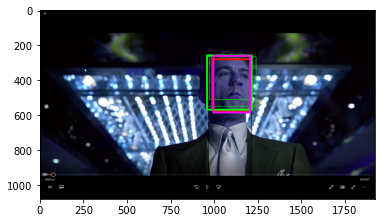

In [32]:
plt.imshow(annotated)


# Color Blue = Dlib
# Red =  Mobilenet
# Green = MTCNN
# Purple = YOLO

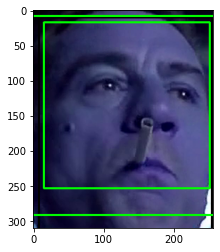

In [33]:
plt.imshow(crop_image(frame,mtcnn_bboxes))

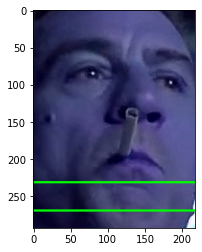

In [34]:
plt.imshow(crop_image(frame,mobilenet_bboxes))

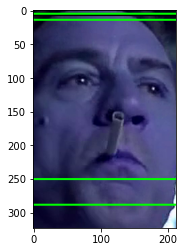

In [35]:
plt.imshow(crop_image(frame,yolo_bboxes))

MTCNN Detection Time: 1.3078901767730713
YOLO Detection Time: 0.16356253623962402
Mobilenet Detection Time: 0.1047208309173584
Dlib Detection time: 41.21357703208923
Mobilenet is 12.489302895287446times faster than MTCNN
Blazeface is 0.0025409304034886824times faster than Mobilenet
Mobilenet is 1.5618911233496724times faster than YOLO


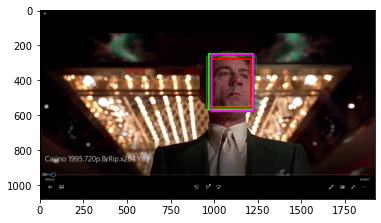

In [36]:
video = sample

cap = cv2.VideoCapture(video)
ret , frame = cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
dlib_time,dlib_bboxes = get_dlib_face(frame)
mtcnn_time,mtcnn_bboxes = get_mtcnn_face(frame)
mobilnet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes = get_yolo_face(frame)
print("MTCNN Detection Time: " + str(mtcnn_time))
print("YOLO Detection Time: " + str(yolo_time))
print("Mobilenet Detection Time: " + str(mobilenet_time))
print("Dlib Detection time: " + str(dlib_time))
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/dlib_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')
if dlib_bboxes==[]:
    print('Dlib is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('mobilenet is unable to detect face in this frame.')
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
#annotated=annotate_image(annotated,dlib_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
plt.imshow(annotated)

MTCNN Detection Time: 1.103513240814209
YOLO Detection Time: 0.17304468154907227
Mobilenet Detection Time: 0.1047208309173584
Dlib Detection time: 41.35724425315857
Mobilenet is 10.537666967950805times faster than MTCNN
Blazeface is 0.00253210369328127times faster than Mobilenet
Mobilenet is 1.652438010978278times faster than YOLO


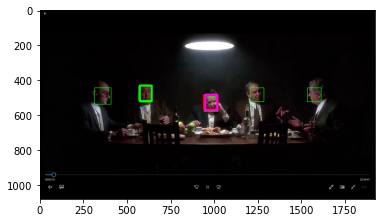

In [37]:

video = r'F:\CollegeStuff\Dataset for Experiment for face detection\dataset experiment2.mp4'
cap=cv2.VideoCapture(video)    
ret,frame=cap.read()
frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
dlib_time,dlib_bboxes = get_dlib_face(frame)
mtcnn_time,mtcnn_bboxes = get_mtcnn_face(frame)
mobilnet_time,mobilenet_bboxes=get_mobilenet_face(frame)
yolo_time,yolo_bboxes = get_yolo_face(frame)
print("MTCNN Detection Time: " + str(mtcnn_time))
print("YOLO Detection Time: " + str(yolo_time))
print("Mobilenet Detection Time: " + str(mobilenet_time))
print("Dlib Detection time: " + str(dlib_time))
print('Mobilenet is '+str(mtcnn_time/mobilenet_time)+'times faster than MTCNN')
print('Blazeface is '+str(mobilenet_time/dlib_time)+'times faster than Mobilenet')
print('Mobilenet is '+str(yolo_time/mobilenet_time)+'times faster than YOLO')
if dlib_bboxes==[]:
    print('Dlib is unable to detect face in this frame.')
if mtcnn_bboxes==[]:
    print('MTCNN is unable to detect face in this frame.')
if mobilenet_bboxes==[]:
    print('mobilenet is unable to detect face in this frame.')
if yolo_bboxes==[]:
    print('mobilenet is unable to detect face in this frame.')
annotated=annotate_image(frame,mobilenet_bboxes,(255,0,0))
annotated=annotate_image(annotated,mtcnn_bboxes,(0,255,0))
#annotated=annotate_image(annotated,dlib_bboxes,(0,0,255))
annotated=annotate_image(annotated,yolo_bboxes,(255,0,255))
plt.imshow(annotated)